In [83]:
import numpy as np
import dython as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import optuna as optuna

### Dataset

In [42]:
train_path = 'datasets/aerolineas/train.csv'
test_path = 'datasets/aerolineas/test.csv'

In [43]:
def load_dataset(path):
    df = pd.read_csv(path)
    # Drop index-like column
    df.drop(columns=[df.columns[0]], inplace=True)
    # Drop "id" column, since it's useless
    df.drop(columns=[df.columns[0]], inplace=True)
    # Drop nulls.
    df = df[df['Arrival Delay in Minutes'].notnull()]
    # Add target numeric. Will do with encoding.
    #df["satisfacion_num"] = df["satisfaction"].map(
        #{s_lvl: s_int for s_int, s_lvl in enumerate(df["satisfaction"].unique())}
    #)

    return df

In [44]:
train = load_dataset(train_path) 
test = load_dataset(test_path)

### Baseline (Logistic Regression)

#### Preprocessing

In [45]:
with pd.option_context('display.max_columns', None):
    display(train.head())

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [31]:
# For logistic regression, we need need all numeric features.
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103594 non-null  object 
 1   Customer Type                      103594 non-null  object 
 2   Age                                103594 non-null  int64  
 3   Type of Travel                     103594 non-null  object 
 4   Class                              103594 non-null  object 
 5   Flight Distance                    103594 non-null  int64  
 6   Inflight wifi service              103594 non-null  int64  
 7   Departure/Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking             103594 non-null  int64  
 9   Gate location                      103594 non-null  int64  
 10  Food and drink                     103594 non-null  int64  
 11  Online boarding                    103594 no

In [46]:
# We need gender, customer type, type of travel and class, as well as target.
for colname in ['Gender', 'Customer Type', 'Type of Travel', 'Class']:
    print(f'{colname} uniques: {train[colname].unique()}')

Gender uniques: ['Male' 'Female']
Customer Type uniques: ['Loyal Customer' 'disloyal Customer']
Type of Travel uniques: ['Personal Travel' 'Business travel']
Class uniques: ['Eco Plus' 'Business' 'Eco']


In [52]:
# We can go binary coding except for Class. We'll use one-hot encoding
# since cardinality is low. 
train = pd.get_dummies(
    train,
    columns=train.select_dtypes(include="object").columns,
    drop_first=True,
    dtype=int,
)
test = pd.get_dummies(
    test,
    columns=test.select_dtypes(include="object").columns,
    drop_first=True,
    dtype=int,
)

In [53]:
with pd.option_context('display.max_columns', None):
    display(test.head())

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,52,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,0,0,0,1,0,1
1,36,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,0,0,0,0,0,1
2,20,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,1,1,0,1,0,0
3,44,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1,0,0,0,0,1
4,49,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,0,0,0,1,0,1


In [77]:
# Get features and targets.
y_train = train['satisfaction_satisfied']
x_train = train.drop(columns=['satisfaction_satisfied'])
y_test = test['satisfaction_satisfied']
x_test = test.drop(columns=['satisfaction_satisfied'])

In [78]:
print(
    f"Train Y: {y_train.shape}\nTrain X: {x_train.shape}\nTest Y: {y_test.shape}\nTest X: {x_test.shape}"
)

Train Y: (103594,)
Train X: (103594, 23)
Test Y: (25893,)
Test X: (25893, 23)


#### Regression

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [93]:
# Columns to scale. Columns that are a 1 to 5 "satisfaction" score will be #
# scaled with min max, the rest with standard.
scale_cols = [col for col in list(x_train.columns) if "_" not in col]
scale_standr_cols = [
    "Age",
    "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
]
scale_minmax_cols = [col for col in scale_cols if col not in scale_standr_cols]

In [94]:
# Pipeline + Fit.
preprocessor = ColumnTransformer(
    transformers=[
        ('ssc', StandardScaler(), scale_standr_cols),
        ('smn', MinMaxScaler(), scale_minmax_cols)
    ]
)

logreg = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegressionCV(cv=10, random_state=42)),
    ]
)

logreg.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ssc', ...), ('smn', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


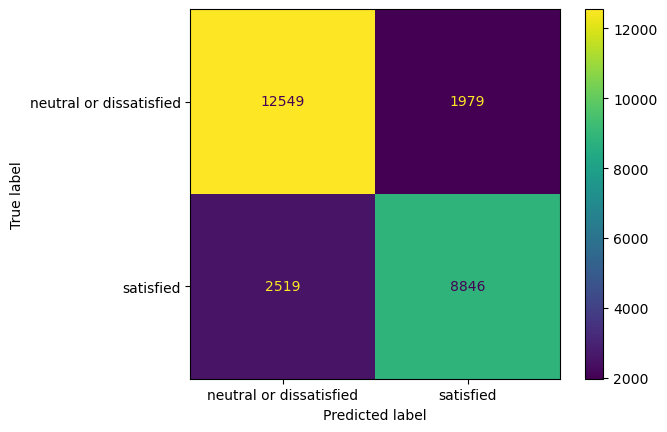

In [95]:
# Confusion matrix to visualize results without threshold optimization.
y_pred = logreg.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['neutral or dissatisfied', 'satisfied'])
disp.plot()
plt.show()

In [96]:
# Classification report.
print(classification_report(y_test, y_pred, target_names=['neutral or dissatisfied', 'satisfied']))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.83      0.86      0.85     14528
              satisfied       0.82      0.78      0.80     11365

               accuracy                           0.83     25893
              macro avg       0.83      0.82      0.82     25893
           weighted avg       0.83      0.83      0.83     25893



#### Threshold Tuning

In [122]:
# Tune threshold.
from sklearn.model_selection import TunedThresholdClassifierCV

logreg_optimized = TunedThresholdClassifierCV(
    logreg,
    scoring='roc_auc',
    store_cv_results=True,
)

logreg_optimized.fit(x_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,scoring,'roc_auc'
,response_method,'auto'
,thresholds,100
,cv,None
,refit,True
,n_jobs,None
,random_state,None
,store_cv_results,True
,transformers,"[('ssc', ...), ('smn', ...)]"
,remainder,'drop'


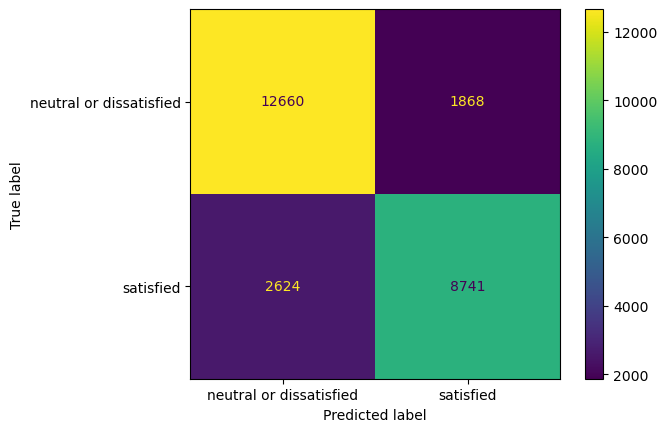

In [125]:
# Confusion matrix to visualize results.
y_pred = logreg_optimized.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['neutral or dissatisfied', 'satisfied'])
disp.plot()
plt.show()

In [126]:
# Classification report.
print(classification_report(y_test, y_pred, target_names=['neutral or dissatisfied', 'satisfied']))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.83      0.87      0.85     14528
              satisfied       0.82      0.77      0.80     11365

               accuracy                           0.83     25893
              macro avg       0.83      0.82      0.82     25893
           weighted avg       0.83      0.83      0.83     25893



In [128]:
from sklearn.metrics import roc_auc_score

# average auc across folds
avg_auc_train = logreg_optimized.best_score_
# Compare auc in the test set.
auc_test_optimized = roc_auc_score(y_test, logreg_optimized.predict(x_test))
auc_test = roc_auc_score(y_test, logreg.predict(x_test))

print(f"Average AUC on the training set: {avg_auc_train:.5f}")
print(f"AUC on the test set: {auc_test_optimized:.5f}")
print(f"AUC on the test set (original model): {auc_test:.5f}")
print(f"Threshold: {logreg_optimized.best_threshold_: .5f}")

Average AUC on the training set: 0.82275
AUC on the test set: 0.82027
AUC on the test set (original model): 0.82107
Threshold:  0.51374


#### Conclusion

Optimizing threshold doesn't seem to modify results that much.

Metrics seem to improve slightly and accuracy is barely improved as well. 

At least, we now have a baseline.

## k-NN